# Titanic Data Science Solutions


### This notebook is a companion to the book [Data Science Solutions](https://www.amazon.com/Data-Science-Solutions-Startup-Workflow/dp/1520545312). 

The notebook walks us through a typical workflow for solving data science competitions at sites like Kaggle.

There are several excellent notebooks to study data science competition entries. However many will skip some of the explanation on how the solution is developed as these notebooks are developed by experts for experts. The objective of this notebook is to follow a step-by-step workflow, explaining each step and rationale for every decision we take during solution development.

## Workflow stages

The competition solution workflow goes through seven stages described in the Data Science Solutions book.

1. Question or problem definition.
2. Acquire training and testing data.
3. Wrangle, prepare, cleanse the data.
4. Analyze, identify patterns, and explore the data.
5. Model, predict and solve the problem.
6. Visualize, report, and present the problem solving steps and final solution.
7. Supply or submit the results.

The workflow indicates general sequence of how each stage may follow the other. However there are use cases with exceptions.

- We may combine mulitple workflow stages. We may analyze by visualizing data.
- Perform a stage earlier than indicated. We may analyze data before and after wrangling.
- Perform a stage multiple times in our workflow. Visualize stage may be used multiple times.
- Drop a stage altogether. We may not need supply stage to productize or service enable our dataset for a competition.


## Question and problem definition

Competition sites like Kaggle define the problem to solve or questions to ask while providing the datasets for training your data science model and testing the model results against a test dataset. The question or problem definition for Titanic Survival competition is [described here at Kaggle](https://www.kaggle.com/c/titanic).

> Knowing from a training set of samples listing passengers who survived or did not survive the Titanic disaster, can our model determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not.

We may also want to develop some early understanding about the domain of our problem. This is described on the [Kaggle competition description page here](https://www.kaggle.com/c/titanic). Here are the highlights to note.

- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Workflow goals

The data science solutions workflow solves for seven major goals.

**Classifying.** We may want to classify or categorize our samples. We may also want to understand the implications or correlation of different classes with our solution goal.

**Correlating.** One can approach the problem based on available features within the training dataset. Which features within the dataset contribute significantly to our solution goal? Statistically speaking is there a [correlation](https://en.wikiversity.org/wiki/Correlation) among a feature and solution goal? As the feature values change does the solution state change as well, and visa-versa? This can be tested both for numerical and categorical features in the given dataset. We may also want to determine correlation among features other than survival for subsequent goals and workflow stages. Correlating certain features may help in creating, completing, or correcting features.

**Converting.** For modeling stage, one needs to prepare the data. Depending on the choice of model algorithm one may require all features to be converted to numerical equivalent values. So for instance converting text categorical values to numeric values.

**Completing.** Data preparation may also require us to estimate any missing values within a feature. Model algorithms may work best when there are no missing values.

**Correcting.** We may also analyze the given training dataset for errors or possibly innacurate values within features and try to corrent these values or exclude the samples containing the errors. One way to do this is to detect any outliers among our samples or features. We may also completely discard a feature if it is not contribting to the analysis or may significantly skew the results.

**Creating.** Can we create new features based on an existing feature or a set of features, such that the new feature follows the correlation, conversion, completeness goals.

**Charting.** How to select the right visualization plots and charts depending on nature of the data and the solution goals.

## Refactor Release 2017-Jan-29

We are significantly refactoring the notebook based on (a) comments received by readers, (b) issues in porting notebook from Jupyter kernel (2.7) to Kaggle kernel (3.5), and (c) review of few more best practice kernels.

### User comments

- Combine training and test data for certain operations like converting titles across dataset to numerical values. (thanks @Sharan Naribole)
- Correct observation - nearly 30% of the passengers had siblings and/or spouses aboard. (thanks @Reinhard)
- Correctly interpreting logistic regresssion coefficients. (thanks @Reinhard)

### Porting issues

- Specify plot dimensions, bring legend into plot.


### Best practices

- Performing feature correlation analysis early in the project.
- Using multiple plots instead of overlays for readability.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

## Acquire data

The Python Pandas packages helps us work with our datasets. We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run certain operations on both datasets together.

In [3]:
train_df = pd.read_csv('../../Data/train.csv')
test_df = pd.read_csv('../../Data/test.csv')
combine = [train_df, test_df]

## Analyze by describing data

Pandas also helps describe the datasets answering following questions early in our project.

**Which features are available in the dataset?**

Noting the feature names for directly manipulating or analyzing these. These feature names are described on the [Kaggle data page here](https://www.kaggle.com/c/titanic/data).

In [4]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

- Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.

**Which features are numerical?**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Age, Fare. Discrete: SibSp, Parch.

In [5]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Which features are mixed data types?**

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

In [6]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

Helping us during converting goal.

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

In [7]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

**What is the distribution of numerical feature values across the samples?**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived representative of the actual survival rate at 32%.
- Most passengers (> 75%) did not travel with parents or children.
- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<1%) within age range 65-80.

In [8]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**What is the distribution of categorical features?**

- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
- Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Roebling, Mr. Washington Augustus II",male,CA. 2343,G6,S
freq,1,577,7,4,644


### Assumtions based on data analysis

We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating.**

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

**Completing.**

1. We may want to complete Age feature as it is definitely correlated to survival.
2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

**Correcting.**

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**Creating.**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.

**Classifying.**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived. 
3. The upper-class passengers (Pclass=1) were more likely to have survived.

## Analyze by pivoting features

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

In [10]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [11]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [12]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [13]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Analyze by visualizing data

Now we can continue confirming some of our assumptions using visualizations for analyzing the data.

### Correlating numerical features

Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

Note that x-axis in historgram visualizations represents the count of samples or passengers.

**Observations.**

- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**Decisions.**

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

- We should consider Age (our assumption classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (creating #3).

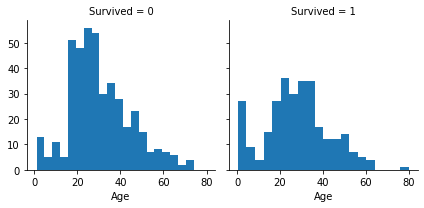

In [14]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features

We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.

**Observations.**

- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

**Decisions.**

- Consider Pclass for model training.

The `size` parameter has been renamed to `height`; please update your code.


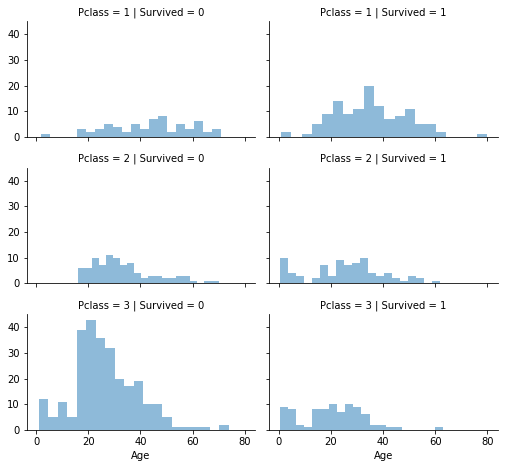

In [15]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features

Now we can correlate categorical features with our solution goal.

**Observations.**

- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

**Decisions.**

- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

The `size` parameter has been renamed to `height`; please update your code.
Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.


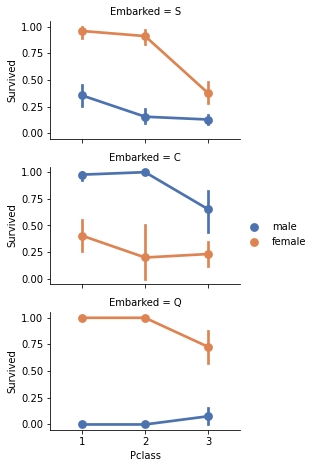

In [16]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Correlating categorical and numerical features

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

**Observations.**

- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**Decisions.**

- Consider banding Fare feature.

The `size` parameter has been renamed to `height`; please update your code.
Using the barplot function without specifying `order` is likely to produce an incorrect plot.


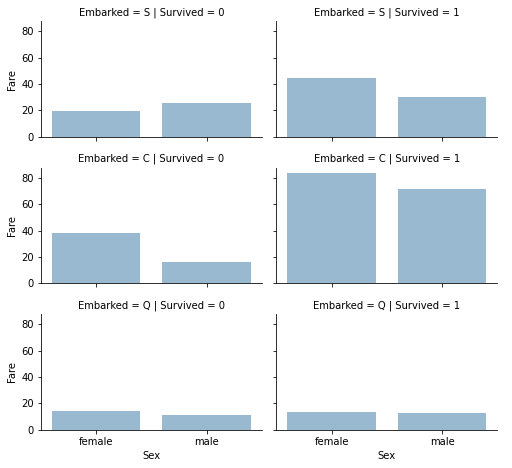

In [17]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Wrangle data

We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

### Correcting by dropping features

This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin (correcting #2) and Ticket (correcting #1) features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [18]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

### Creating new feature extracting from existing

We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features.

In the following code we extract Title feature using regular expressions. The RegEx pattern `(\w+\.)` matches the first word which ends with a dot character within Name feature. The `expand=False` flag returns a DataFrame.

**Observations.**

When we plot Title, Age, and Survived, we note the following observations.

- Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
- Survival among Title Age bands varies slightly.
- Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

**Decision.**

- We decide to retain the new Title feature for model training.

In [19]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as `Rare`.

In [20]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


We can convert the categorical titles to ordinal.

In [21]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset.

In [22]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Converting a categorical feature

Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.

In [23]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### Completing a numerical continuous feature

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

1. A simple way is to generate random numbers between mean and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation).

2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using [median](https://en.wikipedia.org/wiki/Median) values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2.

The `size` parameter has been renamed to `height`; please update your code.


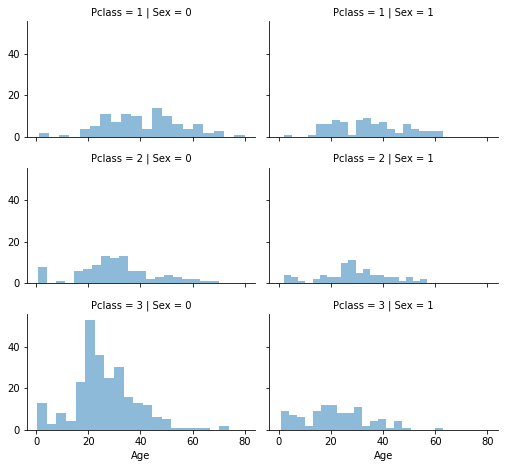

In [24]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.

In [25]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [26]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Let us create Age bands and determine correlations with Survived.

In [27]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Let us replace Age with ordinals based on these bands.

In [28]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


We can not remove the AgeBand feature.

In [29]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Create new feature combining existing features

We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [30]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We can create another feature called IsAlone.

In [31]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.

In [32]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


We can also create an artificial feature combining Pclass and Age.

In [33]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature

Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [34]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [35]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical feature to numeric

We can now convert the EmbarkedFill feature by creating a new numeric Port feature.

In [36]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### Quick completing and converting a numeric feature

We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.

In [37]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


We can not create FareBand.

In [38]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Convert the Fare feature to ordinal values based on the FareBand.

In [39]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


And the test dataset.

In [40]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## Model, predict and solve

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

In [41]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

Note the confidence score generated by the model based on our training dataset.

In [ ]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

- Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.
- Inversely as Pclass increases, probability of Survived=1 decreases the most.
- This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.
- So is Title as second highest positive correlation.

In [ ]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

Next we model using Support Vector Machines which are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of **two categories**, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine).

Note that the model generates a confidence score which is higher than Logistics Regression model.

In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. Reference [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

KNN confidence score is better than Logistics Regression but worse than SVM.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

The model generated confidence score is the lowest among the models evaluated so far.

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference [Wikipedia](https://en.wikipedia.org/wiki/Perceptron).

In [ ]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

In [ ]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

The model confidence score is the highest among models evaluated so far.

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

The next model Random Forests is one of the most popular. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

In [ ]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

### Model evaluation

We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set. 

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('../output/submission.csv', index=False)

Our submission to the competition site Kaggle results in scoring 3,883 of 6,082 competition entries. This result is indicative while the competition is running. This result only accounts for part of the submission dataset. Not bad for our first attempt. Any suggestions to improve our score are most welcome.

## References

This notebook has been created based on great work done solving the Titanic competition and other sources.

- [A journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic)
- [Getting Started with Pandas: Kaggle's Titanic Competition](https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests)
- [Titanic Best Working Classifier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier)

## Fairness 

In [42]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [43]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [44]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [45]:
privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]
dataset_orig = StandardDataset(train_df,
                                  label_name='Survived',
                                  protected_attribute_names=['Sex'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])



In [46]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.553130


In [6]:
data_orig_train = pd.read_pickle('../../Results/RF/1-titanic-tutorial_Train.pkl')
data_orig_test = pd.read_pickle('../../Results/RF/1-titanic-tutorial_Test.pkl')


In [15]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from xgboost import XGBClassifier
import pickle

#data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
num_estimators = 100

model = RandomForestClassifier(n_estimators=100)

mdl = model.fit(X_train, y_train)

with open('../../Results/RF/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/RF/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/RF/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 



"\nwith open('../../Results/RF/' + nb_fname + '.pkl', 'wb') as f:\n        pickle.dump(mdl, f)\n\nwith open('../../Results/RF/' + nb_fname + '_Train' + '.pkl', 'wb') as f:\n    pickle.dump(data_orig_train, f) \n    \nwith open('../../Results/RF/' + nb_fname + '_Test' + '.pkl', 'wb') as f:\n    pickle.dump(data_orig_test, f) \n"

In [48]:
final_metrics = []
accuracy = []
f1= []
from statistics import mean
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier


for i in range(0,20):
    
    data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
    print(i)
    X_train = data_orig_train.features
    y_train = data_orig_train.labels.ravel()

    X_test = data_orig_test.features
    y_test = data_orig_test.labels.ravel()
    model = RandomForestClassifier(n_estimators=100)
  
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)

    
element_wise_std =  np.std(final_metrics, 0, ddof=1)
print("STD " + str(element_wise_std))
final_metrics = list(map(mean, zip(*final_metrics)))
accuracy = mean(accuracy)
f1 = mean(f1)
final_metrics[4] = np.log(final_metrics[4])
print(final_metrics)
print(sum(final_metrics[1:]))
print(accuracy)
print(f1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
STD [5.91607978 0.07874305 0.10397253 0.1061756  0.03616578 0.02255819]
[9.5, -0.646481814307849, -0.5129060048808701, 0.4688198028625575, -1.8645646144783383, 0.15111482387013347]
-2.4040178069343665
0.8057835820895523
0.7375442901240542


In [18]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = RandomForestClassifier(n_estimators = i)
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)


invalid value encountered in double_scalars


In [19]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()
acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/RF/' + nb_fname + '.csv')
final_result

divide by zero encountered in log


,classifier,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99
accuracy,0.809701,0.619403,0.805970,0.723881,0.723881,0.660448,0.805970,0.787313,0.805970,0.805970,...,0.809701,0.805970,0.805970,0.779851,0.787313,0.787313,0.787313,0.787313,0.805970,0.809701
f1,0.721311,0.000000,0.717391,0.430769,0.463768,0.491620,0.717391,0.622517,0.717391,0.717391,...,0.721311,0.717391,0.717391,0.646707,0.641509,0.622517,0.622517,0.622517,0.717391,0.721311
statistical_parity_difference,-0.987805,0.000000,-1.000000,-0.341463,-0.439024,-0.078023,-1.000000,-0.597561,-1.000000,-1.000000,...,-0.987805,-1.000000,-1.000000,-0.792683,-0.695122,-0.597561,-0.597561,-0.597561,-1.000000,-0.987805
equal_opportunity_difference,-1.000000,0.000000,-1.000000,-0.424242,-0.484848,0.020202,-1.000000,-0.712121,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-0.818182,-0.772727,-0.712121,-0.712121,-0.712121,-1.000000,-1.000000
average_abs_odds_difference,0.968750,0.000000,1.000000,0.212121,0.367424,0.120101,1.000000,0.418561,1.000000,1.000000,...,0.968750,1.000000,1.000000,0.752841,0.573864,0.418561,0.418561,0.418561,1.000000,0.968750
disparate_impact,-inf,NaN,-inf,-inf,-inf,-0.259412,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
theil_index,0.165787,0.478999,0.166997,0.323129,0.310171,0.286188,0.166997,0.233245,0.166997,0.166997,...,0.165787,0.166997,0.166997,0.214583,0.221115,0.233245,0.233245,0.233245,0.166997,0.165787
